# Packages

In [1]:
# Internal Packages
from core.parameters import *
from core.net_list import NET_LIST
from core.scheduler_list import SCHEDULER_LIST
from core.optimizer_list import OPTIMIZER_LIST
from core.loss_list import LOSS_LIST
from nets.ResNet50Attention import ResNet50Attention
from common.myfunctions import plot_confusion_matrix
from common.customloss import QuadraticKappa, WeightedMultiLabelLogLoss, WeightedMultiLabelFocalLogLoss
import common.weights_initialization as w_init

# Base Packages
import os
import glob
import copy
import time
import pandas as pd
import numpy as np
from PIL import Image
#import pydicom

# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Torchvision Packages
import torchvision.transforms.functional as TF
from torchvision import transforms, utils, datasets
from torchvision.models import densenet121, vgg16, resnet50, inception_v3

# Miscellaneous Packages
from efficientnet_pytorch import EfficientNet
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils import class_weight
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline

# Cuda

In [2]:
if torch.cuda.is_available(): #GPU
    is_cuda = True
    cuda_list = ','.join([str(c) for c in CUDA_DEVICES])
    device = torch.device("cuda:{}".format(cuda_list))
    print("Total GPU is", torch.cuda.device_count())
    
else: #CPU
    is_cuda = False
    device = "cpu"

# Set seed for CUDA (all GPU)    
#torch.cuda.manual_seed_all(SEED)    
    
print('Cuda:', is_cuda, ', Device:', device)

Total GPU is 4
Cuda: True , Device: cuda:0


# Custom Dataset

In [3]:
class CustomDataset(Dataset):

    def __init__(self, X, y, img_folder, img_ext='png', transform=None):
        """
        Args:
            X (dataframe): Dataframe with images ID.
            y (dataframe): Dataframe with labels annotations.
            img_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = X
        self.y = y
        self.img_folder = img_folder
        self.img_ext = img_ext
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, self.X.iloc[idx, 0] + '.' + self.img_ext)
        
        image = np.load(img_name)
        
        label = self.y.iloc[idx].to_numpy()
        
        if self.transform:
       
           image = self.transform(TF.to_pil_image(image))

        return (image,label)

# Load Dataset

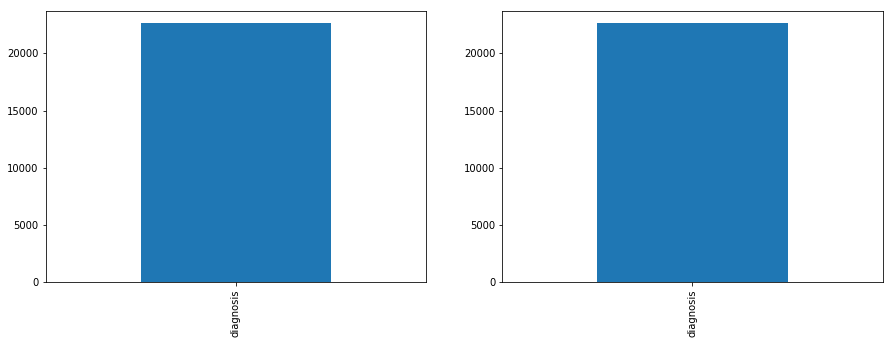

In [4]:
# Load Dataset
data = pd.read_csv(TRAIN_LABELS)

# Delete Blacklist
data = data.loc[~data[ID_COLUMN].isin(BLACK_LIST_ID)]

# Plot All Labels
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
data[LABEL_COLUMN].sum().plot.bar()

# Plot Sample Labels
plt.subplot(1,2,2)
data[LABEL_COLUMN].sum().plot.bar()

### Calc Classes Weight

In [5]:
if NUM_CLASSES > 1:
    
    distrib_freq = data[LABEL_COLUMN].sum().to_numpy()
    
    w_classes = distrib_freq.sum() / (NUM_CLASSES * distrib_freq)
    
    for l in LOSSES:
        if 'weight' in LOSS_LIST[l]:
            LOSS_LIST[l]['weight'] = torch.from_numpy(w_classes).to(device)

# Train Test Split

In [6]:
x = data.drop([*LABEL_COLUMN], axis=1)
y = data[LABEL_COLUMN]

# Criando o dataframe de treine e teste com base no dataframe anteriormente criado
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = TEST_SPLIT, random_state = SEED)

# Sample

In [9]:
# Sample Dataset
print('Train: ', len(X_train))
print('Test: ', len(X_test))

if SAMPLE_FRAC < 1.0:
    df_train = pd.concat([X_train, y_train], axis=1)
    df_train = df_train.sample(frac = SAMPLE_FRAC)
    X_train = df_train.drop([*LABEL_COLUMN], axis=1)
    y_train = df_train[LABEL_COLUMN]
    print('Sample Train: ', len(X_train))
    

Train:  27151
Test:  11637


# Data augmentation

In [7]:
train_transf = transforms.Compose(TRAIN_AUGMENTATION)
test_transf = transforms.Compose(TEST_AUGMENTATION)

train_dataset = CustomDataset(X=X_train, 
                              y=y_train, 
                              img_folder=TRAIN_DIR,
                              img_ext=IMAGE_FORMAT, 
                              transform=train_transf)

test_dataset = CustomDataset(X=X_test, 
                             y=y_test, 
                             img_folder=TEST_DIR, 
                             img_ext=IMAGE_FORMAT,
                             transform=test_transf)

# Garregando os dados
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Make a dict to pass though train function
dataloaders_dict = {'train': train_loader, 'val': test_loader}

# Model

In [8]:
def getModel(model_name, num_classes):
    
    model_parameters = NET_LIST[model_name]
    base_model = model_parameters['base_model']
    
    if base_model=='densenet121':
        
        model = densenet121(pretrained=model_parameters['pretrained'])
        model.classifier = nn.Linear(1024, num_classes)   
            
    elif base_model=='densenet121multitask':
        
        model = densenet121multitask(pretrained=model_parameters['pretrained'])
        model.classifier = nn.Linear(1024, num_classes)   
        model.aux_classifier = nn.Linear(1024, 1)   
            
    elif base_model=='vgg16':
        
        model = vgg16(pretrained=model_parameters['pretrained'])
        model.classifier[6] = nn.Linear(4096, num_classes) 
    
    elif base_model=='resnet50':
        
        model = resnet50(pretrained=model_parameters['pretrained'])
        model.fc = nn.Linear(2048, num_classes) 
        
    elif base_model=='ResNet50Attention':
        model = ResNet50Attention(num_classes, 
                                  attention=True, 
                                  pretrained=model_parameters['pretrained'])
        
    elif base_model=='ResNet50AttentionMultiTask':
        model = ResNet50AttentionMultiTask(num_classes, 
                                  attention=True, 
                                  pretrained=model_parameters['pretrained'])
        
    elif base_model=='inception_v3':
        
        model = inception_v3(pretrained=model_parameters['pretrained'])
        model.fc = nn.Linear(2048, num_classes) 
        model.AuxLogits.fc = nn.Linear(768, num_classes)
        
    elif base_model=='efficientnetb7':
        
        model = EfficientNet.from_pretrained('efficientnet-b7')
        model._fc = nn.Linear(2560, NUM_CLASSES) 
        
    # Parallel    
    # Obs.: when load model, the DataParallel is already in the model.
    if is_cuda & (torch.cuda.device_count() > 1) & (not model_parameters['is_inception']):
        
        if not CUDA_DEVICES:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = nn.DataParallel(model) 
        else:
            print("Let's use", CUDA_DEVICES, "GPUs!")
            model = nn.DataParallel(model, device_ids = CUDA_DEVICES) # When load checkpoint, the DataParallel is already in the model.
    
    # Frozen Layers
    for name, param in model.named_parameters():
        for l in model_parameters['layers_to_frozen']:
            if l in name:
                param.requires_grad = False

    if LOAD_CHECKPOINT:

        # Get lastest model file
        list_of_files = glob.glob(MODEL_DIR + f'/{base_model}_*.pt') # * means all if need specific format then *.csv
        
        if len(list_of_files) > 0:
            
            latest_file = max(list_of_files, key=os.path.getctime)

            print(f'Loading state dict from checkpoint \n\t {latest_file}')

            model.load_state_dict(torch.load(latest_file, map_location=device))
    else:
        model.apply(w_init.weight_init) #Custom weight initialization
                
    if is_cuda:
        model = model.to(device)
        
    return model

# Scheduler

In [9]:
def getScheduler(scheduler_name, optimizer):
    
    if not scheduler_name:
        return None

    scheduler_parameters = SCHEDULER_LIST[scheduler_name]

    if scheduler_parameters['function'] == 'ReduceLROnPlateau':

        scheduler = ReduceLROnPlateau(optimizer, 
                                      mode = scheduler_parameters['mode'], 
                                      factor = scheduler_parameters['factor'], 
                                      patience = scheduler_parameters['patience'], 
                                      verbose = scheduler_parameters['verbose'], 
                                      threshold = scheduler_parameters['threshold'], 
                                      threshold_mode = scheduler_parameters['threshold_mode'], 
                                      cooldown = scheduler_parameters['cooldown'], 
                                      min_lr = scheduler_parameters['min_lr'], 
                                      eps = scheduler_parameters['eps'])

    return scheduler

# Optimizer

In [10]:
def getOptimizer(optimizer_name, model):

    params_to_update = []
    
    for name, param in model.named_parameters():
    
        if param.requires_grad == True:
        
            params_to_update.append(param)
            
            #print("\t",name)
            
    opt_parameters = OPTIMIZER_LIST[optimizer_name]

    if opt_parameters['function'] == 'Adam':
        
        optimizer = torch.optim.Adam(params_to_update, 
                                     lr = opt_parameters['lr'],
                                     betas = opt_parameters['betas'],
                                     eps = opt_parameters['eps'],
                                     weight_decay = opt_parameters['weight_decay'],
                                     amsgrad = opt_parameters['amsgrad']
                                    )
    elif opt_parameters['function'] == 'SGD':
        
        optimizer = torch.optim.SGD(params_to_update, 
                                     lr = opt_parameters['lr'],
                                     weight_decay = opt_parameters['weight_decay'],
                                     momentum = opt_parameters['momentum']
                                    )

    return optimizer

# Loss Function

In [11]:
def getLossFunction(loss_nme):
    
    loss_parameters = LOSS_LIST[loss_nme]

    if loss_parameters['function'] == 'SmoothL1Loss':
        criterion = nn.SmoothL1Loss(
            reduction = loss_parameters['reduction']
        )

    elif loss_parameters['function'] == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss(
            weight = loss_parameters['weight'],
            size_average = loss_parameters['size_average'],
            ignore_index = loss_parameters['ignore_index'],
            reduce = loss_parameters['reduce'],
            reduction = loss_parameters['reduction']
        )

    elif loss_parameters['function'] == 'NLLLoss':

        criterion = nn.NLLLoss(
            weight = loss_parameters['weight'],
            size_average = loss_parameters['size_average'],
            ignore_index = loss_parameters['ignore_index'],
            reduce = loss_parameters['reduce'],
            reduction = loss_parameters['reduction']
        )

    elif loss_parameters['function'] == 'QuadraticKappa':
        criterion = QuadraticKappa(
            n_classes = loss_parameters['n_classes']
        )
        
    elif loss_parameters['function'] == 'WeightedMultiLabelLogLoss':

        criterion = WeightedMultiLabelLogLoss(
            n_classes = loss_parameters['n_classes'],
            weight = loss_parameters['weight']
        )
    elif loss_parameters['function'] == 'WeightedMultiLabelFocalLogLoss':

        criterion = WeightedMultiLabelFocalLogLoss(
            n_classes = loss_parameters['n_classes'],
            weight = loss_parameters['weight'],
            gamma = loss_parameters['gamma']
        )
        
    return criterion

def onehot(labels, num_classes):
    return torch.zeros(len(labels), num_classes).scatter_(1, labels.unsqueeze(1).cpu(), 1.).cuda()


def calcLoss(criterion, loss_name, outputs, labels):
    
    loss_parameters = LOSS_LIST[loss_name]
    last_layer = loss_parameters['last_layer']
    
    if last_layer == 'softmax':
        outputs = torch.softmax(outputs, dim=1)
        preds_loss = torch.argmax(outputs, 1)
        preds_metric = torch.argmax(outputs, 1)
        
    elif last_layer == 'logsoftmax':
        logsoftmax = nn.LogSoftmax(dim=1)
        outputs = logsoftmax(outputs)
        preds_loss = outputs
        preds_metric = torch.argmax(torch.exp(outputs),  1) ### AINDA NÃO TESTADO.
        
        #OBS.: torch.exp(outputs) revert log
        
    elif last_layer == 'sigmoid':        
        outputs = torch.sigmoid(outputs)
        preds_loss = outputs > 0.5
        preds_metric = torch.argmax(outputs, 1)
        
    elif last_layer == 'linear':        
        preds_loss = outputs
        preds_metric = outputs
        labels = labels.type(torch.float)

    # Transform label from shape 1 to (1, n_classes)
    if loss_parameters['onehotlabel']:
        labels = onehot(labels, NUM_CLASSES)
        
    loss = criterion(preds_loss, labels)
            
    return loss, preds_metric

# Metric Function

In [12]:
def calcMetric(preds, labels):
    
    if METRIC == 'KAPPA':
        preds = np.round(preds)
        score = cohen_kappa_score(preds, labels, weights='quadratic')
    
    elif METRIC == 'ACC':
        score = sum(preds == labels)
        
    return score

# Train Function

In [13]:
def train_model(model, model_name, loss_name, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):

    since = time.time()

    best_score = 0.0 if SAVE_BEST == 'metric' else float("inf")
    epoch_metric = 0.0
    
    print(model_name)
    print('-' * 100)

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
                
        print('Learning Rate:', lr)
        tensorboard.add_scalar('LR', lr, epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_preds = []
            running_labels = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        
                        loss1, preds = calcLoss(criterion, loss_name, outputs, labels)
                        loss2, preds = calcLoss(criterion, loss_name, aux_outputs, labels)
                        
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        
                        outputs = model(inputs)
                        
                        loss, preds = calcLoss(criterion, loss_name, outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                running_preds = np.append(running_preds, preds.squeeze().cpu().detach().numpy())
                running_labels = np.append(running_labels, labels.squeeze().cpu().detach().numpy())
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if METRIC:
                epoch_metric = calcMetric(running_preds, running_labels)
                tensorboard.add_scalar('{} {}'.format(METRIC, phase), epoch_metric, epoch)
            
            print('{} Loss: {:.4f} {}: {:.4f}'.format(phase, epoch_loss, METRIC, epoch_metric))
            
            # Write loss into Tensorboard
            tensorboard.add_scalar('Loss {}'.format(phase), epoch_loss, epoch)

            # Save the best model
            if phase == 'val':
                
                if scheduler:
                    scheduler.step(epoch_loss)
                
                save_flag = False
                
                if SAVE_BEST == 'metric' and epoch_metric > best_score:
                    
                    best_score = epoch_metric
                    save_flag = True
                    
                elif SAVE_BEST == 'loss' and epoch_loss < best_score:
                    
                    best_score = epoch_loss
                    save_flag = True
                
                if save_flag:
                    print('Saving the best model at {}'.format(MODEL_DIR))
                    torch.save(model.state_dict(), MODEL_DIR + '/' + model_name + '_' + SAVE_BEST + str(best_score) + '.pt')
            
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val {}: {:4f}'.format(SAVE_BEST, best_score))

    return best_score


# Grid Search

In [14]:
model_name_list = []
metric_list = []

for m in MODELS:
    
    model_parameters = NET_LIST[m]
    base_model = model_parameters['base_model']
    model = getModel(m, NUM_CLASSES)
    
    for o in OPTIMIZERS:
            
        optimizer = getOptimizer(o, model)
        
        for s in SCHEDULERS:
    
            scheduler = getScheduler(s, optimizer)
            
            for l in LOSSES:

                criterion = getLossFunction(l)

                model_name = f'{base_model}_{m}{s}{o}{l}ImgSize{str(INPUT_SIZE)}SampleFrac{SAMPLE_FRAC}'

                tensorboard = SummaryWriter(comment = model_name)

                summary(model, input_size=(CHANNELS, INPUT_SIZE, INPUT_SIZE))
                
                # Train and evaluate
                best_score = train_model(
                    model, 
                    model_name, 
                    l,
                    dataloaders_dict, 
                    criterion, 
                    optimizer, 
                    scheduler,
                    num_epochs=NUM_EPOCH, 
                    is_inception=NET_LIST[m]['is_inception'])

                model_name_list.append(model_name)
                metric_list.append(best_score)
            

Let's use [0, 1, 2, 3] GPUs!
Loading state dict from checkpoint 
	 /mnt/diabetic_retinopathy_v2/models/resnet50_ResNet50ReduceLROnPlateauAmsGradAdam0005SmoothL1LossImgSize299SampleFrac1.0_loss0.15619487431621576.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]           4,096
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
           Conv2

train Loss: 0.2131 KAPPA: 0.6573
val Loss: 0.1670 KAPPA: 0.7521
Saving the best model at /mnt/diabetic_retinopathy_v2/models

Epoch 1/199
----------
Learning Rate: 5e-05
train Loss: 0.2049 KAPPA: 0.6739
val Loss: 0.1794 KAPPA: 0.7245

Epoch 2/199
----------
Learning Rate: 5e-05
train Loss: 0.1977 KAPPA: 0.6915
val Loss: 0.1817 KAPPA: 0.7238

Epoch 3/199
----------
Learning Rate: 5e-05
train Loss: 0.1965 KAPPA: 0.6928
val Loss: 0.1843 KAPPA: 0.7166

Epoch 4/199
----------
Learning Rate: 5e-05
train Loss: 0.1910 KAPPA: 0.7040
val Loss: 0.1865 KAPPA: 0.7272

Epoch 5/199
----------
Learning Rate: 5e-05
train Loss: 0.1907 KAPPA: 0.7039
val Loss: 0.1834 KAPPA: 0.7226

Epoch 6/199
----------
Learning Rate: 5e-05
train Loss: 0.1881 KAPPA: 0.7115
val Loss: 0.1758 KAPPA: 0.7377

Epoch 7/199
----------
Learning Rate: 5e-05
train Loss: 0.1901 KAPPA: 0.7061
val Loss: 0.1723 KAPPA: 0.7516

Epoch 8/199
----------
Learning Rate: 5e-05
train Loss: 0.1854 KAPPA: 0.7132
val Loss: 0.1816 KAPPA: 0.7535

Ep

KeyboardInterrupt: 

# The Best Model Metrics

In [ ]:
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(metric_list))  # the x locations for the groups
ax.barh(ind, metric_list, width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(model_name_list, minor=False)
plt.xlabel('Loss')
for i, v in enumerate(metric_list):
    ax.text(v, i, str(v))